Le modèle de Markov va estimer quelle classe a généré les postériors (vecteurs de 4 valeurs) des observations de température.
Comme on veut lisser notre température, on va plutôt prendre la probabilité des classes sachant les observations. Malheuresement, le modèle de markov caché marche "trop" bien, c'est-à-dire qu'il arrive à déterminer les classes presque systématiquement la bonne classe et avec une probabilité très forte. Ainsi les les probabilité des classes sachant les observations sont presque binaires et la température que j'estime comme une somme des moyennes pondérées par ces probas est très discontinues (car ces probas sont quasi binaires)

In [1]:
import csv
import numpy as np
from math import *
import warnings

obs = [] #array to store observed temperatures
labels = [] #array to store true class labels
posteriors = [] #array to store posteriors from all classes
activations = [] #array to store activations from all classes
R = 0 #Observation noise variance

#Retrive temperatures and true class labels from csv file
with open('pour_martin_ix70_iy115_iz26.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    l = 0
    for row in spamreader:
        if l == 0:
            l = 1 #first row is titles, we skip it
        else:
            arr = row[0].split('\t')
            obs.append(float(arr[1]))
            labels.append(int(arr[2]))
            tmpP= []
            tmpA = []
            for k in range(4):
                tmpP.append(float(arr[3+k]))
                tmpA.append(float(arr[7+k]))
            posteriors.append(tmpP)
            activations.append(tmpA)

n = len(obs) #number of observations
labels = np.array(labels)
posteriors = np.array(posteriors)

#Class means and variances
gaus_mean = np.array([4.70226841574216, 7.70938140771444, 15.4116575244064, 18.5364702094555])
gaus_var = np.array([0.164338465357345, 1.27622462394194, 2.02625911575517, 0.232444749797503])**2

In [2]:
K = 4
M = np.zeros((K,K))

#Compute transition matrix
for t in range(len(labels)-1):
    i = labels[t] - (5-K)
    j = labels[t+1] - (5-K)
    M[i,j] += 1
for i in range(K):
    if sum(M[i,:]) != 0:
        M[i,:] /= sum(M[i,:])

M4 = M #transition matrix using 4 classes
M3 = M[1:,1:] #transition matrix using only 3 classes (gets rid of first class)
print(M)
print(M3)

#Used to match classes found by HMM with true classes
def map_labels(l,mapping):
    new = np.array(l)
    for n in range(len(l)):
        temp = int(l[n])
        new[n] = np.nonzero(mapping == temp)[0][0]
        #new[n] = mapping[temp]
    return new

def map_mat(mat, mapping):
    M,N = mat.shape
    new = np.zeros((M,N))
    for m in range(M):
        for n in range(N):
            new[m,n] = mat[m, int(mapping[n])]
    return new

[[ 0.          0.          0.          0.        ]
 [ 0.          0.76344086  0.23655914  0.        ]
 [ 0.          0.17073171  0.69105691  0.13821138]
 [ 0.          0.          0.22972973  0.77027027]]
[[ 0.76344086  0.23655914  0.        ]
 [ 0.17073171  0.69105691  0.13821138]
 [ 0.          0.22972973  0.77027027]]


In [10]:
from hmmlearn import hmm

K = 3
warnings.filterwarnings('ignore')

model = hmm.GaussianHMM(n_components=3, covariance_type="diag")
model.startprob_ = np.array([0.33, 0.33, 0.33]) #HMM start distribution
model.transmat_ = M3 #HMM transition matrix
model.fit(posteriors[:,1:]) #Train model

GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
      covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
      min_covar=0.001, n_components=3, n_iter=10, params='stmc',
      random_state=None, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
      verbose=False)

In [11]:
#State-membership probabilities for each sample from posteriors
filt_post = model.predict_proba(posteriors[:,1:])
#State found by algo for each sample from posteriors
est_lab = model.predict(posteriors[:,1:])

In [15]:
#Sort data so that classes found by training match with true classes

mapping = np.array([0, 1, 2])

sorted_lab = map_labels(est_lab, mapping) + 2*np.ones((n,))
sorted_post = map_mat(filt_post, mapping)

Pour estimer la température, j'utilise la somme des moyennes des classes pondérées par les probas trouvés par le modèle

Populating the interactive namespace from numpy and matplotlib


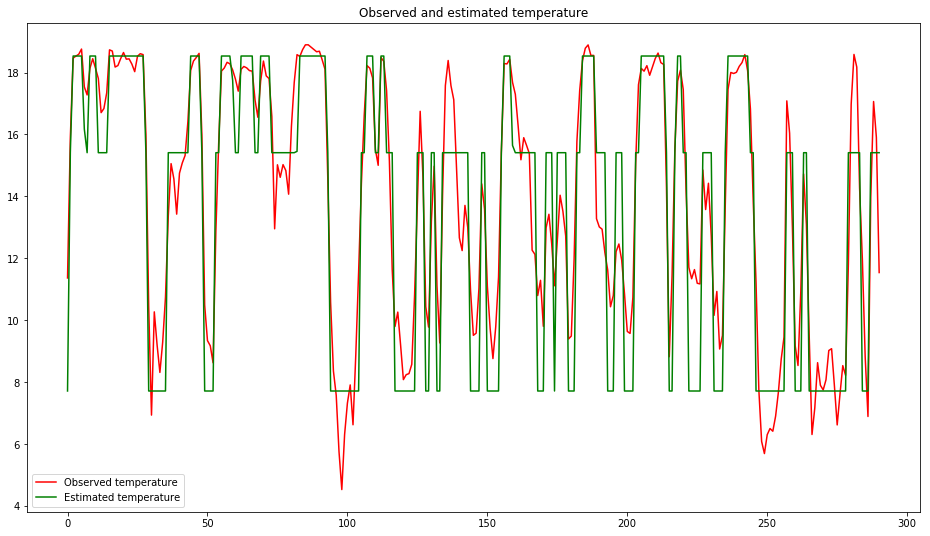

In [16]:
%pylab inline
pylab.rcParams['figure.figsize'] = (16.0, 9.0)


warnings.filterwarnings('ignore')

time  = np.array(range(n)) # time vector

est_temp = sorted_post.dot(np.transpose(gaus_mean[4-K:]))
plot(time, obs,'r', label='Observed temperature')
#plot(time, est_temp,'b', label='Filtered temperature')
plot(time, est_temp,'g', label='Estimated temperature')
title('Observed and estimated temperature')
legend()

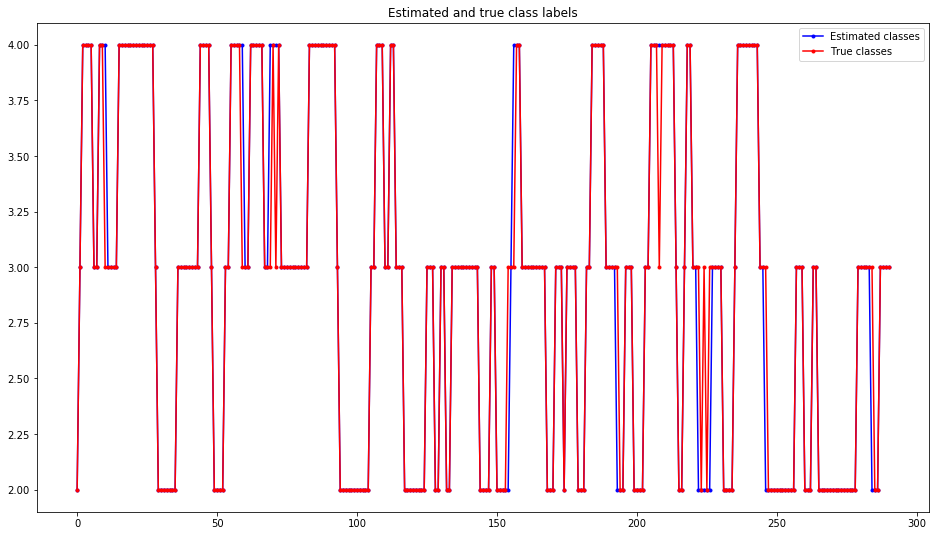

In [18]:
plot(range(n),sorted_lab, '.-b', label='Estimated classes')
plot(range(n),labels, '.-r', label='True classes')
legend()
title('Estimated and true class labels')

In [ ]:
K = 3
step = 4
warnings.filterwarnings('ignore')

model = hmm.GaussianHMM(n_components=3, covariance_type="diag")
model.startprob_ = np.array([0.33, 0.33, 0.33]) #HMM start distribution
model.transmat_ = M3 #HMM transition matrix
model.fit(posteriors[:,1:]) #Train model